In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [2]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc("font", family = font_name)

# 데이터 처리하기

In [3]:
# 데이터 불러오기
df = pd.read_csv("./data/train.csv")

In [4]:
# 필요없는 열 삭제하기
df = df.drop(columns = ["site", "sid", "ldate", "lrate", "llevel"], axis = 1)

In [5]:
# 필요없는 열 삭제하기
df = df.iloc[:, :-20]

In [6]:
df.head()

,leaktype,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,80HZ,...,5030HZ,5040HZ,5050HZ,5060HZ,5070HZ,5080HZ,5090HZ,5100HZ,5110HZ,5120HZ
0,out,0,18,19,16,20,19,17,16,20,...,23,24,19,16,21,18,17,18,22,20
1,out,0,4,2,4,6,4,6,8,8,...,2,2,2,2,2,2,2,4,2,2
2,out,0,0,0,3,3,3,3,5,14,...,3,3,3,3,3,3,3,3,3,3
3,out,0,2,2,2,2,2,2,2,2,...,2,4,2,4,4,4,4,4,4,4
4,out,0,3,3,3,3,3,3,3,5,...,5,5,5,5,5,5,5,5,5,5


In [7]:
# leaktype을 라벨인코딩
encoder = LabelEncoder()

In [8]:
encoder.fit(df["leaktype"])

LabelEncoder()

In [9]:
df["leaktype_Encoder"] = encoder.transform(df["leaktype"])
df.head()

,leaktype,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,80HZ,...,5040HZ,5050HZ,5060HZ,5070HZ,5080HZ,5090HZ,5100HZ,5110HZ,5120HZ,leaktype_Encoder
0,out,0,18,19,16,20,19,17,16,20,...,24,19,16,21,18,17,18,22,20,4
1,out,0,4,2,4,6,4,6,8,8,...,2,2,2,2,2,2,4,2,2,4
2,out,0,0,0,3,3,3,3,5,14,...,3,3,3,3,3,3,3,3,3,4
3,out,0,2,2,2,2,2,2,2,2,...,4,2,4,4,4,4,4,4,4,4
4,out,0,3,3,3,3,3,3,3,5,...,5,5,5,5,5,5,5,5,5,4


In [10]:
df["leaktype_Encoder"].value_counts()

leaktype_Encoder
2    19704
4    17539
0    13273
3     7019
1     5029
Name: count, dtype: int64

- 4: normal
- 3: noise
- 2: out
- 1: other
- 0: in

In [11]:
x = df.drop(columns = ["leaktype", "leaktype_Encoder"])
y = df["leaktype_Encoder"]

# 데이터 분할 및 LGBM 세팅

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=14)

In [13]:
print(x_train.shape, x_test.shape)

(46923, 513) (15641, 513)


In [14]:
train_data = lgb.Dataset(x_train, label = y_train)

In [15]:
test_data = lgb.Dataset(x_test, label = y_test)

In [17]:
# r기본으로 하이퍼파라미터 설정
params = {"objective": "multiclass", 
          "num_class" : len(y.unique()),
          "metric": "multi_logloss",
          "boosting_type": "gbdt"}

# 모델 생성

In [18]:
model = lgb.train(params, train_data, valid_sets = [test_data], num_boost_round=100)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68565
[LightGBM] [Info] Number of data points in the train set: 46923, number of used features: 512
[LightGBM] [Info] Start training from score -1.548927
[LightGBM] [Info] Start training from score -2.519578
[LightGBM] [Info] Start training from score -1.156248
[LightGBM] [Info] Start training from score -2.187617
[LightGBM] [Info] Start training from score -1.272314


In [19]:
y_pred = model.predict(x_test)

In [20]:
y_pred = [list(p).index(max(p)) for p in y_pred]

# 모델 평가

In [21]:
# 분류별 예측 정확도 평가
accuracy = accuracy_score(y_test, y_pred)

In [22]:
print(f"Acuuracy: {accuracy:.4f}")

Acuuracy: 0.8753


In [23]:
# 혼동 행렬(Confusion Maxtrix) 생성하고 시각화하기
matrix = confusion_matrix(y_test, y_pred)

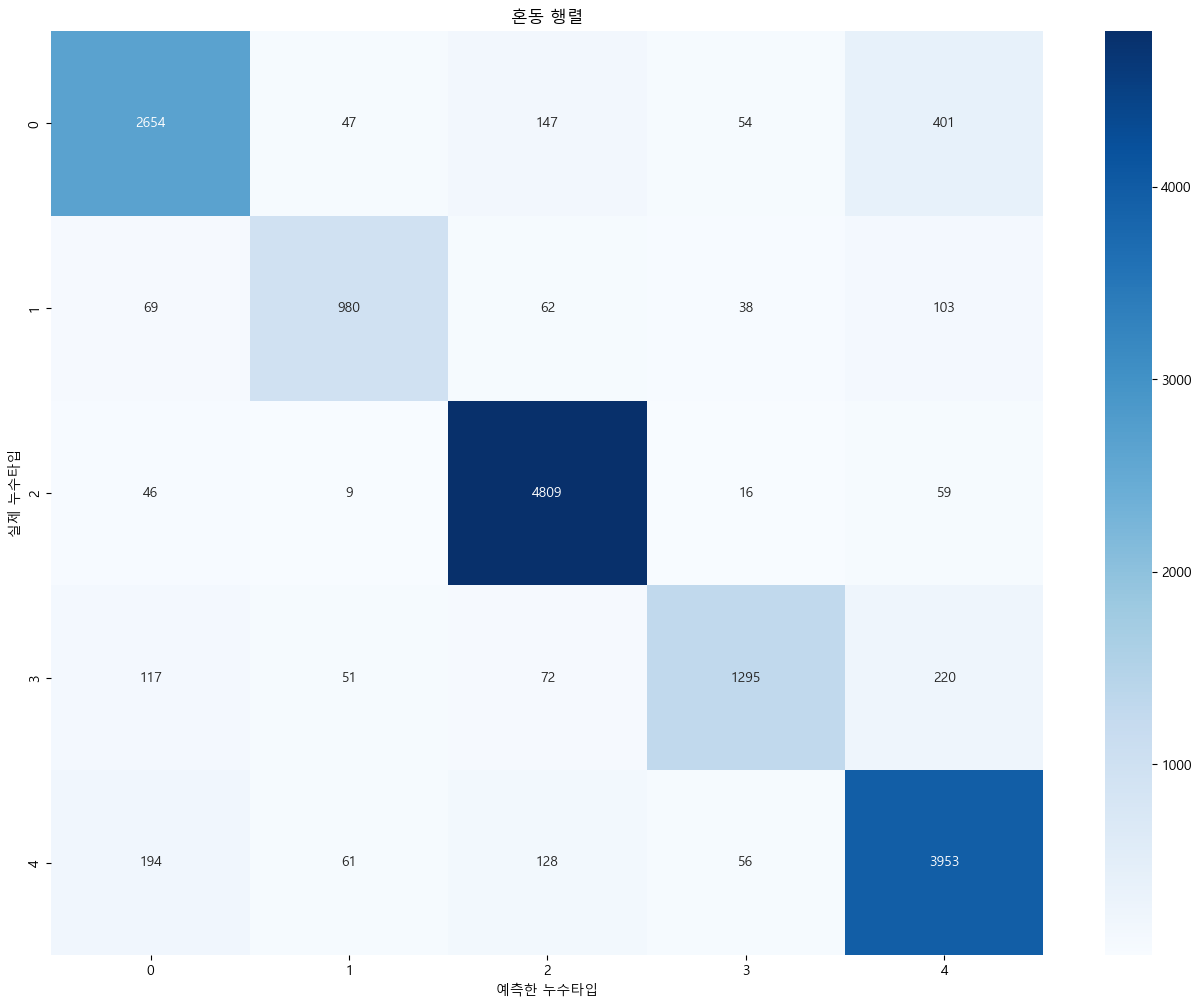

In [24]:
plt.figure(figsize = (16, 12))

sns.heatmap(matrix, annot=True, fmt = "d", cmap = "Blues",
            xticklabels = np.unique(y_test), yticklabels = np.unique(y_test))
plt.title("혼동 행렬")
plt.xlabel("예측한 누수타입")
plt.ylabel("실제 누수타입")
plt.savefig("혼동 행렬.png", dpi = 300)
plt.show()

# 결과 해설

- 4: 정상음
- 3: 노이즈
- 2: 아웃
- 1: 환경음
- 0: 인

In [25]:
print("다중분류 레포트입니다:")
print(classification_report(y_test, y_pred))

다중분류 레포트입니다:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      3303
           1       0.85      0.78      0.82      1252
           2       0.92      0.97      0.95      4939
           3       0.89      0.74      0.81      1755
           4       0.83      0.90      0.87      4392

    accuracy                           0.88     15641
   macro avg       0.87      0.84      0.85     15641
weighted avg       0.88      0.88      0.87     15641



- Out과 Normal:
  - 을 분류할 때 가장 높은 성능을 보임
  - 특히 Out의 경우 Precision(0.92)과 Recall(0.97)이 매우 높아, 모델이 해당 데이터를 잘 구분하는 것으로 판단
- Noise:
  - Precision(0.74)이 다른 클래스보다 낮아, 분류 잘 못함
  - Recall(0.81)은 다소 나쁘지 않지만, 다른 클래스와 비교했을 때 F1-Score(0.77)가 가장 낮음
- In:
  - 전반적으로 잘 예측됨
- Other:
  - Recall(0.78)로 낮음
  - 분류 잘 못하는데 개선할 필요가 있음

- 역시 데이터의 불균형(노이즈와 환경음)은 분류의 정확성을 떨어트리는 것을 알 수 있음

# 그렇다면 교차 검증을 해봅시다

In [26]:
model2 = LGBMClassifier(objective="multiclass", num_class=len(y.unique()), random_state=42)

In [27]:
# 평가 지표 설정
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision_macro": make_scorer(precision_score, average="macro"),
    "recall_macro": make_scorer(recall_score, average="macro"),
    "f1_macro": make_scorer(f1_score, average="macro")
}

In [31]:
# 교차검증 하기
cv_results = cross_validate(
    estimator= model2,
    X=x_train,
    y=y_train,
    cv=5,
    scoring=scoring,
    return_train_score=True)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65227
[LightGBM] [Info] Number of data points in the train set: 37538, number of used features: 512
[LightGBM] [Info] Start training from score -1.548917
[LightGBM] [Info] Start training from score -2.519435
[LightGBM] [Info] Start training from score -1.156238
[LightGBM] [Info] Start training from score -2.187654
[LightGBM] [Info] Start training from score -1.272361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64813
[LightGBM] [Info] Number of data points in the train set: 37538, number of used features: 512
[LightGBM] [Info] Start training from score -1.548917
[LightGBM] [Info] Start training from score -2.519766
[LightGBM] [Info] Start training from sc

In [32]:
# 결과 출력
for metric, scores in cv_results.items():
    print(f"{metric}: {scores.mean():.4f}")

fit_time: 14.3919
score_time: 0.1247
test_accuracy: 0.8703
train_accuracy: 0.9444
test_precision_macro: 0.8631
train_precision_macro: 0.9445
test_recall_macro: 0.8281
train_recall_macro: 0.9296
test_f1_macro: 0.8430
train_f1_macro: 0.9365


## 교차검증 해석

- 학습 데이터와 테스트 데이터 성능의 차이를 통해 약간의 과적합이 있는 것으로 보임
- 특히, train_accuracy와 test_accuracy, 그리고 train_f1_macro와 test_f1_macro 간의 차이가 꽤 큼..

## 그렇다면 하이퍼 파라미터를 바꿔서 다시 해보자

In [47]:
# 하이퍼파라미터 재설정
params = {"objective": "multiclass", 
          "num_class" : len(y.unique()),
          "metric": "multi_logloss",
          "boosting_type": "gbdt",
          "max_depth" : 6,
          "min_child_samples" : 20,
          "num_leaves" : 127}

In [48]:
hyper_model = model = lgb.train(params, train_data, valid_sets = [test_data], num_boost_round=100)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68565
[LightGBM] [Info] Number of data points in the train set: 46923, number of used features: 512
[LightGBM] [Info] Start training from score -1.548927
[LightGBM] [Info] Start training from score -2.519578
[LightGBM] [Info] Start training from score -1.156248
[LightGBM] [Info] Start training from score -2.187617
[LightGBM] [Info] Start training from score -1.272314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [49]:
y_pred_hyper = hyper_model.predict(x_test)

In [50]:
y_pred_hyper = [list(p).index(max(p)) for p in y_pred_hyper]

In [51]:
# 분류별 예측 정확도 평가
accuracy_hyper = accuracy_score(y_test, y_pred_hyper)

In [52]:
print(f"accuracy_hyper: {accuracy_hyper:.4f}")

accuracy_hyper: 0.8440


# 데이터를 줄여서도 해볼까

In [41]:
x_sub, x_val, y_sub, y_val = train_test_split(x_train, y_train, test_size = 0.25, random_state=14)

In [42]:
print(x_sub.shape, x_val.shape)

(35192, 513) (11731, 513)


In [43]:
train_cross_data = lgb.Dataset(x_sub, label = y_sub)

In [44]:
test_cross_data = lgb.Dataset(x_val, label = y_val)

In [45]:
cross_model = lgb.train(params, train_cross_data, valid_sets = [test_cross_data], num_boost_round=100)

[LightGBM] [Warning] Unknown parameter: metirc
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=6) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=64) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Unknown parameter: metirc
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=6) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=64) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64004
[LightGBM] [Info] Number of data points in the train set: 35192, number of used features: 512
[LightGBM] [W

- 하이퍼파라미터 튜닝 뭘 더 어떻게 해야될지 모르겠음...

In [46]:
y_cross_pred = model.predict(x_val)

In [47]:
y_cross_pred = [list(p).index(max(p)) for p in y_cross_pred]

In [48]:
cross_accuracy = accuracy_score(y_val, y_cross_pred)

In [49]:
print(f"cross_acuuracy: {cross_accuracy:.4f}")

cross_acuuracy: 0.8281


In [50]:
print("Cross 다중분류 레포트입니다:")
print(classification_report(y_val, y_cross_pred))

Cross 다중분류 레포트입니다:
              precision    recall  f1-score   support

           0       0.84      0.69      0.76      2453
           1       0.82      0.74      0.78       951
           2       0.86      0.98      0.92      3727
           3       0.92      0.60      0.73      1303
           4       0.76      0.88      0.82      3297

    accuracy                           0.83     11731
   macro avg       0.84      0.78      0.80     11731
weighted avg       0.83      0.83      0.82     11731

